## Import Dependencies

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import joblib

## Dataset 1

### Load Data

In [2]:
# loading dataset
df = pd.read_csv('../data/ad_click_dataset.csv')

### Creating new dataset 
- the new dataset below is created from the first dataset but it only contains 1000 entries

In [3]:
# removed 1000 entries from the first dataset
# to create a new dataset and store in variable df1

df1 = df.head(1000)

In [4]:
df1

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...,...,...
995,6143,User6143,29.0,Non-Binary,Mobile,Bottom,NaN,NaN,1
996,5498,User5498,NaN,NaN,Tablet,Side,Education,Morning,1
997,8973,User8973,26.0,Male,Tablet,Side,NaN,Night,0
998,1214,User1214,26.0,Female,Mobile,Bottom,News,Evening,1


In [5]:
# checking for null values
print(df1.isnull().sum())

id                    0
full_name             0
age                 481
gender              467
device_type         178
ad_position         191
browsing_history    484
time_of_day         196
click                 0
dtype: int64


### Cleaning dataset 1 (df1)

In [6]:
# Convert only object (string entries) columns to lowercase
# i.e convert all text entries in columns to lowercase

df1 = df1.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)

In [7]:
# Define 'gender_change' for values to replace unknown, non-binary, or NaN
gender_change = (df1['gender'].isin(['unknown', 'non-binary'])) | (df1['gender'].isna())

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42) 

# Replace with random 'male' or 'female'
df1.loc[gender_change, 'gender'] = np.random.choice(['male', 'female'], size=gender_change.sum())

In [8]:
df1

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,user670,22.0,male,desktop,top,shopping,afternoon,1
1,3044,user3044,NaN,male,desktop,top,NaN,NaN,1
2,5912,user5912,41.0,female,NaN,side,education,night,1
3,5418,user5418,34.0,male,NaN,NaN,entertainment,evening,1
4,9452,user9452,39.0,male,NaN,NaN,social media,morning,0
...,...,...,...,...,...,...,...,...,...
995,6143,user6143,29.0,female,mobile,bottom,NaN,NaN,1
996,5498,user5498,NaN,female,tablet,side,education,morning,1
997,8973,user8973,26.0,male,tablet,side,NaN,night,0
998,1214,user1214,26.0,female,mobile,bottom,news,evening,1


In [9]:
# Keep only 'male' and 'female' rows
df1 = df1[df1['gender'].isin(['male', 'female'])]

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1000 non-null   int64  
 1   full_name         1000 non-null   object 
 2   age               519 non-null    float64
 3   gender            1000 non-null   object 
 4   device_type       822 non-null    object 
 5   ad_position       809 non-null    object 
 6   browsing_history  516 non-null    object 
 7   time_of_day       804 non-null    object 
 8   click             1000 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 70.4+ KB


#### Data manipulation - to fill up empty entries in columns randomly
- time_of_day
- age
- device_type
- ad_position
- browsing_history

#### time_of_day column

In [10]:
# replacing 'unknown' and 'NaN' entries in time_of_day column with random options - morning, night, e.t.c.

# Define possible time labels
time_labels = ['morning', 'afternoon', 'evening', 'night']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42) 

# Replace 'unknown' and 'NaN' entries with a random choice
change = (df1['time_of_day'] == 'unknown') | (df1['time_of_day'].isna())
df1.loc[change, 'time_of_day'] = np.random.choice(time_labels, size=change.sum())

In [11]:
df1

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,user670,22.0,male,desktop,top,shopping,afternoon,1
1,3044,user3044,NaN,male,desktop,top,NaN,evening,1
2,5912,user5912,41.0,female,NaN,side,education,night,1
3,5418,user5418,34.0,male,NaN,NaN,entertainment,evening,1
4,9452,user9452,39.0,male,NaN,NaN,social media,morning,0
...,...,...,...,...,...,...,...,...,...
995,6143,user6143,29.0,female,mobile,bottom,NaN,afternoon,1
996,5498,user5498,NaN,female,tablet,side,education,morning,1
997,8973,user8973,26.0,male,tablet,side,NaN,night,0
998,1214,user1214,26.0,female,mobile,bottom,news,evening,1


#### ad_position column

In [12]:
# replacing 'unknown' or 'NaN' entries in 'ad_position' column with random options - top, side, bottom.

# Define possible ad_position labels
ad_position_labels = ['top', 'bottom', 'side']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42) 

# Replace 'unknown' and 'NaN' entries with a random choice
position_change = (df1['ad_position'] == 'unknown') | (df1['ad_position'].isna())
df1.loc[position_change, 'ad_position'] = np.random.choice(ad_position_labels, size=position_change.sum())

In [13]:
df1

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,user670,22.0,male,desktop,top,shopping,afternoon,1
1,3044,user3044,NaN,male,desktop,top,NaN,evening,1
2,5912,user5912,41.0,female,NaN,side,education,night,1
3,5418,user5418,34.0,male,NaN,side,entertainment,evening,1
4,9452,user9452,39.0,male,NaN,top,social media,morning,0
...,...,...,...,...,...,...,...,...,...
995,6143,user6143,29.0,female,mobile,bottom,NaN,afternoon,1
996,5498,user5498,NaN,female,tablet,side,education,morning,1
997,8973,user8973,26.0,male,tablet,side,NaN,night,0
998,1214,user1214,26.0,female,mobile,bottom,news,evening,1


#### device_type column

In [14]:
# replacing 'unknown' or 'NaN' entries in device_type column with random options - desktop, tablet, mobile.

# Define possible device_type labels
type_labels = ['desktop', 'mobile', 'tablet']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42)

# Replace 'unknown' or 'NaN' entries with a random choice
type_change = (df1['device_type'] == 'unknown') | (df1['device_type'].isna())
df1.loc[type_change, 'device_type'] = np.random.choice(type_labels, size=type_change.sum())

In [15]:
df1

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,user670,22.0,male,desktop,top,shopping,afternoon,1
1,3044,user3044,NaN,male,desktop,top,NaN,evening,1
2,5912,user5912,41.0,female,tablet,side,education,night,1
3,5418,user5418,34.0,male,desktop,side,entertainment,evening,1
4,9452,user9452,39.0,male,tablet,top,social media,morning,0
...,...,...,...,...,...,...,...,...,...
995,6143,user6143,29.0,female,mobile,bottom,NaN,afternoon,1
996,5498,user5498,NaN,female,tablet,side,education,morning,1
997,8973,user8973,26.0,male,tablet,side,NaN,night,0
998,1214,user1214,26.0,female,mobile,bottom,news,evening,1


#### browsing_history column

In [16]:
# replacing 'unknown' and 'NaN' entries in browsing_history column with random options - shopping, education, e.t.c.

# Define possible browsing_history labels
history_labels = ['shopping', 'education', 'entertainment', 'social media', 'news']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42)

# Replace 'unknown' and 'NaN' entries with a random choice
history_change = (df1['browsing_history'] == 'unknown') | (df1['browsing_history'].isna())
df1.loc[history_change, 'browsing_history'] = np.random.choice(history_labels, size=history_change.sum())

In [17]:
df1

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,user670,22.0,male,desktop,top,shopping,afternoon,1
1,3044,user3044,NaN,male,desktop,top,social media,evening,1
2,5912,user5912,41.0,female,tablet,side,education,night,1
3,5418,user5418,34.0,male,desktop,side,entertainment,evening,1
4,9452,user9452,39.0,male,tablet,top,social media,morning,0
...,...,...,...,...,...,...,...,...,...
995,6143,user6143,29.0,female,mobile,bottom,education,afternoon,1
996,5498,user5498,NaN,female,tablet,side,education,morning,1
997,8973,user8973,26.0,male,tablet,side,news,night,0
998,1214,user1214,26.0,female,mobile,bottom,news,evening,1


#### age column

In [18]:
# Fill numeric columns (with empty entries - NaN) with their mean
df1.fillna(df1.mean(numeric_only=True), inplace=True)  # For numeric columns

# Round numeric columns to whole numbers and convert to integer
numeric_cols = df1.select_dtypes(include=['float64', 'int64']).columns
df1[numeric_cols] = df1[numeric_cols].round(0).astype('int')


df1.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,user670,22,male,desktop,top,shopping,afternoon,1
1,3044,user3044,40,male,desktop,top,social media,evening,1
2,5912,user5912,41,female,tablet,side,education,night,1
3,5418,user5418,34,male,desktop,side,entertainment,evening,1
4,9452,user9452,39,male,tablet,top,social media,morning,0


In [19]:
# check for null values
print(df1.isnull().sum())

id                  0
full_name           0
age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64


In [20]:
df1

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,user670,22,male,desktop,top,shopping,afternoon,1
1,3044,user3044,40,male,desktop,top,social media,evening,1
2,5912,user5912,41,female,tablet,side,education,night,1
3,5418,user5418,34,male,desktop,side,entertainment,evening,1
4,9452,user9452,39,male,tablet,top,social media,morning,0
...,...,...,...,...,...,...,...,...,...
995,6143,user6143,29,female,mobile,bottom,education,afternoon,1
996,5498,user5498,40,female,tablet,side,education,morning,1
997,8973,user8973,26,male,tablet,side,news,night,0
998,1214,user1214,26,female,mobile,bottom,news,evening,1


## Dataset 2

### Load data

In [21]:
# loading the dataset
df2 = pd.read_csv('../data/advertising.csv')

In [22]:
# checking for null values
print(df2.isnull().sum())

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64


### Cleaning dataset 2 (df2)

In [23]:
# Convert all text entries in columns to lowercase
df2 = df2.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)

In [24]:
# convert column names to lowercase
df2.columns = df2.columns.str.lower().str.strip().str.replace(" ", "_")

In [25]:
# Convert 'male' column (1 = male, 0 = female) into a new 'gender' column
df2['gender'] = df2['male'].map({1: 'male', 0: 'female'})

In [26]:
# Drop the original 'male' column
df2.drop(columns=['male'], inplace=True)

df2

,daily_time_spent_on_site,age,area_income,daily_internet_usage,ad_topic_line,city,country,timestamp,clicked_on_ad,gender
0,68.95,35,61833.90,256.09,cloned 5thgeneration orchestration,wrightburgh,tunisia,2016-03-27 00:53:11,0,female
1,80.23,31,68441.85,193.77,monitored national standardization,west jodi,nauru,2016-04-04 01:39:02,0,male
2,69.47,26,59785.94,236.50,organic bottom-line service-desk,davidton,san marino,2016-03-13 20:35:42,0,female
3,74.15,29,54806.18,245.89,triple-buffered reciprocal time-frame,west terrifurt,italy,2016-01-10 02:31:19,0,male
4,68.37,35,73889.99,225.58,robust logistical utilization,south manuel,iceland,2016-06-03 03:36:18,0,female
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,fundamental modular algorithm,duffystad,lebanon,2016-02-11 21:49:00,1,male
996,51.30,45,67782.17,134.42,grass-roots cohesive monitoring,new darlene,bosnia and herzegovina,2016-04-22 02:07:01,1,male
997,51.63,51,42415.72,120.37,expanded intangible solution,south jessica,mongolia,2016-02-01 17:24:57,1,male
998,55.55,19,41920.79,187.95,proactive bandwidth-monitored policy,west steven,guatemala,2016-03-24 02:35:54,0,female


In [27]:
# Keep only 'male' and 'female' rows (safe check)
df2 = df2[df2['gender'].isin(['male', 'female'])]

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   daily_time_spent_on_site  1000 non-null   float64
 1   age                       1000 non-null   int64  
 2   area_income               1000 non-null   float64
 3   daily_internet_usage      1000 non-null   float64
 4   ad_topic_line             1000 non-null   object 
 5   city                      1000 non-null   object 
 6   country                   1000 non-null   object 
 7   timestamp                 1000 non-null   object 
 8   clicked_on_ad             1000 non-null   int64  
 9   gender                    1000 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 78.2+ KB


In [28]:
# Fill numeric columns with empty entries (NaN) with their mean
df2.fillna(df2.mean(numeric_only=True), inplace=True)  # For numeric columns

# Round numeric columns to whole numbers and convert to integer
number_cols = df2.select_dtypes(include=['float64', 'int64']).columns
df2[number_cols] = df2[number_cols].round(0).astype('int')


df2.head()

,daily_time_spent_on_site,age,area_income,daily_internet_usage,ad_topic_line,city,country,timestamp,clicked_on_ad,gender
0,69,35,61834,256,cloned 5thgeneration orchestration,wrightburgh,tunisia,2016-03-27 00:53:11,0,female
1,80,31,68442,194,monitored national standardization,west jodi,nauru,2016-04-04 01:39:02,0,male
2,69,26,59786,236,organic bottom-line service-desk,davidton,san marino,2016-03-13 20:35:42,0,female
3,74,29,54806,246,triple-buffered reciprocal time-frame,west terrifurt,italy,2016-01-10 02:31:19,0,male
4,68,35,73890,226,robust logistical utilization,south manuel,iceland,2016-06-03 03:36:18,0,female


In [29]:
# convert 'timestamp' column entries to 'time_of_day' column entries e.g morning, night, etc.

# Function to detect and label timestamps
def label_or_pass(value):
    # Check if value is already a known label (e.g. 'morning')
    if isinstance(value, str) and value.strip().lower() in ['morning', 'afternoon', 'evening', 'night']:
        return value.strip().lower()

    # If it looks like a timestamp (e.g. '2016-02-11 21:49:00'), try to parse
    timestamp_pattern = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$'
    if isinstance(value, str) and re.match(timestamp_pattern, value.strip()):
        dt = pd.to_datetime(value.strip(), format='%Y-%m-%d %H:%M:%S')
        hour = dt.hour
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'
    
    return 'unknown'  # For any unexpected format

# Apply to the column - 'timestamp'
df2['timestamp'] = df2['timestamp'].apply(label_or_pass)

In [30]:
df2

,daily_time_spent_on_site,age,area_income,daily_internet_usage,ad_topic_line,city,country,timestamp,clicked_on_ad,gender
0,69,35,61834,256,cloned 5thgeneration orchestration,wrightburgh,tunisia,night,0,female
1,80,31,68442,194,monitored national standardization,west jodi,nauru,night,0,male
2,69,26,59786,236,organic bottom-line service-desk,davidton,san marino,evening,0,female
3,74,29,54806,246,triple-buffered reciprocal time-frame,west terrifurt,italy,night,0,male
4,68,35,73890,226,robust logistical utilization,south manuel,iceland,night,0,female
...,...,...,...,...,...,...,...,...,...,...
995,73,30,71385,209,fundamental modular algorithm,duffystad,lebanon,night,1,male
996,51,45,67782,134,grass-roots cohesive monitoring,new darlene,bosnia and herzegovina,night,1,male
997,52,51,42416,120,expanded intangible solution,south jessica,mongolia,evening,1,male
998,56,19,41921,188,proactive bandwidth-monitored policy,west steven,guatemala,night,0,female


In [31]:
# checking for null values
print(df2.isnull().sum())

daily_time_spent_on_site    0
age                         0
area_income                 0
daily_internet_usage        0
ad_topic_line               0
city                        0
country                     0
timestamp                   0
clicked_on_ad               0
gender                      0
dtype: int64


## Merging both datasets

In [32]:
# Selecting only the columns needed from each cleaned DataFrame
df1_needed = df1[['age', 'gender', 'browsing_history', 'time_of_day', 
                  'device_type', 'ad_position', 'click']]

df2_needed = df2[['age', 'gender', 'daily_internet_usage', 'timestamp',
                  'daily_time_spent_on_site', 'ad_topic_line', 'clicked_on_ad']]

In [33]:
# Renaming columns in df1 and df2 to align them 

df1_needed = df1_needed.rename(columns={
    'click': 'clicked_on_ad'
})

df2_needed = df2_needed.rename(columns={
    'timestamp': 'time_of_day',
})

In [34]:
# Combining both cleaned datasets
# and merging them into one - combined_df
combined_df = pd.concat([df1_needed, df2_needed], ignore_index=True)

In [35]:
# Bin age into age_group
bins = [0, 17, 24, 34, 44, 54, 64, 100]
labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
combined_df['age_group'] = pd.cut(combined_df['age'], bins=bins, labels=labels, right=True)

combined_df

,age,gender,browsing_history,time_of_day,device_type,ad_position,clicked_on_ad,daily_internet_usage,daily_time_spent_on_site,ad_topic_line,age_group
0,22,male,shopping,afternoon,desktop,top,1,NaN,NaN,NaN,18-24
1,40,male,social media,evening,desktop,top,1,NaN,NaN,NaN,35-44
2,41,female,education,night,tablet,side,1,NaN,NaN,NaN,35-44
3,34,male,entertainment,evening,desktop,side,1,NaN,NaN,NaN,25-34
4,39,male,social media,morning,tablet,top,0,NaN,NaN,NaN,35-44
...,...,...,...,...,...,...,...,...,...,...,...
1995,30,male,NaN,night,NaN,NaN,1,209.0,73.0,fundamental modular algorithm,25-34
1996,45,male,NaN,night,NaN,NaN,1,134.0,51.0,grass-roots cohesive monitoring,45-54
1997,51,male,NaN,evening,NaN,NaN,1,120.0,52.0,expanded intangible solution,45-54
1998,19,female,NaN,night,NaN,NaN,0,188.0,56.0,proactive bandwidth-monitored policy,18-24


In [36]:
# checking for null values
print(combined_df['age_group'].isnull().sum())

0


In [37]:
# normalizing the text to keep data format consistent in the specified column - 'time_of_day'
combined_df['time_of_day'] = combined_df['time_of_day'].astype(str).str.strip().str.lower()

In [38]:
# replacing 'unknown' and 'NaN' entries in browsing_history column with random options - shopping, news, e.t.c.

# Define possible browsing_history labels
hist_labels = ['shopping', 'education', 'entertainment', 'social media', 'news']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42)

# Replace 'unknown' and 'NaN' entries with a random choice
hist_change = (combined_df['browsing_history'] == 'unknown') | (combined_df['browsing_history'].isna())
combined_df.loc[hist_change, 'browsing_history'] = np.random.choice(hist_labels, size=hist_change.sum())

In [39]:
# replacing 'unknown' and 'NaN' entries in device_type column with random options - desktop, tablet, mobile.

# Define possible device_type labels
device_labels = ['desktop', 'mobile', 'tablet']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42)

# Replace 'unknown' and 'NaN' entries with a random choice
device_change = (combined_df['device_type'] == 'unknown') | (combined_df['device_type'].isna())
combined_df.loc[device_change, 'device_type'] = np.random.choice(device_labels, size=device_change.sum())

In [40]:
# replacing 'unknown' and 'NaN' entries in ad_position column with random options - side, top, bottom.

# Define possible ad_position labels
ad_labels = ['top', 'bottom', 'side']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
np.random.seed(42) 

# Replace 'unknown' and 'NaN' entries with a random choice
ad_change = (combined_df['ad_position'] == 'unknown') | (combined_df['ad_position'].isna())
combined_df.loc[ad_change, 'ad_position'] = np.random.choice(ad_labels, size=ad_change.sum())

In [41]:
# Fill numeric columns (with empty entries or NaN entries) with their mean
combined_df.fillna(combined_df.mean(numeric_only=True), inplace=True)  # For numeric columns

# Round numeric columns to whole numbers and convert to integer
numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
combined_df[numeric_cols] = combined_df[numeric_cols].round(0).astype('int')


combined_df

,age,gender,browsing_history,time_of_day,device_type,ad_position,clicked_on_ad,daily_internet_usage,daily_time_spent_on_site,ad_topic_line,age_group
0,22,male,shopping,afternoon,desktop,top,1,180,65,NaN,18-24
1,40,male,social media,evening,desktop,top,1,180,65,NaN,35-44
2,41,female,education,night,tablet,side,1,180,65,NaN,35-44
3,34,male,entertainment,evening,desktop,side,1,180,65,NaN,25-34
4,39,male,social media,morning,tablet,top,0,180,65,NaN,35-44
...,...,...,...,...,...,...,...,...,...,...,...
1995,30,male,education,night,mobile,bottom,1,209,73,fundamental modular algorithm,25-34
1996,45,male,shopping,night,mobile,bottom,1,134,51,grass-roots cohesive monitoring,45-54
1997,51,male,shopping,evening,tablet,side,1,120,52,expanded intangible solution,45-54
1998,19,female,social media,night,tablet,side,0,188,56,proactive bandwidth-monitored policy,18-24


In [42]:
# to find out the min and max values for columns:
# daily_time_spent_on_site AND daily_internet_usage
# in order to bin their values appropriately

print('Daily time spent on site:')
print(combined_df['daily_time_spent_on_site'].describe())
print('\nDaily internet usage')
print(combined_df['daily_internet_usage'].describe())

Daily time spent on site:
count    2000.00000
mean       65.01100
std        11.21208
min        33.00000
25%        65.00000
50%        65.00000
75%        68.00000
max        91.00000
Name: daily_time_spent_on_site, dtype: float64

Daily internet usage
count    2000.00000
mean      179.99800
std        31.04171
min       105.00000
25%       180.00000
50%       180.00000
75%       183.00000
max       270.00000
Name: daily_internet_usage, dtype: float64


In [43]:
# Binning daily time spent on site
site_bins = [0, 30, 50, 70, 90, 110]
site_labels = ['<30 mins', '30–50 mins', '51–70 mins', '71–90 mins', '90+ mins']
combined_df['site_time_group'] = pd.cut(combined_df['daily_time_spent_on_site'], bins=site_bins, labels=site_labels, right=True)

In [44]:
# Binning daily internet usage
usage_bins = [0, 100, 125, 175, 225, 300]
usage_labels = ['<100 MB', '100–125 MB', '126–175 MB', '176–225 MB', '226+ MB']
combined_df['internet_usage_group'] = pd.cut(combined_df['daily_internet_usage'], bins=usage_bins, labels=usage_labels, right=True)

In [45]:
combined_df

,age,gender,browsing_history,time_of_day,device_type,ad_position,clicked_on_ad,daily_internet_usage,daily_time_spent_on_site,ad_topic_line,age_group,site_time_group,internet_usage_group
0,22,male,shopping,afternoon,desktop,top,1,180,65,NaN,18-24,51–70 mins,176–225 MB
1,40,male,social media,evening,desktop,top,1,180,65,NaN,35-44,51–70 mins,176–225 MB
2,41,female,education,night,tablet,side,1,180,65,NaN,35-44,51–70 mins,176–225 MB
3,34,male,entertainment,evening,desktop,side,1,180,65,NaN,25-34,51–70 mins,176–225 MB
4,39,male,social media,morning,tablet,top,0,180,65,NaN,35-44,51–70 mins,176–225 MB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,30,male,education,night,mobile,bottom,1,209,73,fundamental modular algorithm,25-34,71–90 mins,176–225 MB
1996,45,male,shopping,night,mobile,bottom,1,134,51,grass-roots cohesive monitoring,45-54,51–70 mins,126–175 MB
1997,51,male,shopping,evening,tablet,side,1,120,52,expanded intangible solution,45-54,51–70 mins,100–125 MB
1998,19,female,social media,night,tablet,side,0,188,56,proactive bandwidth-monitored policy,18-24,51–70 mins,176–225 MB


In [46]:
## dealing with ad_topic_line column

## Generating dummy but realistic ad topic lines or ad headlines
## to simulate ad headlines creatively

# Example: "Special Offer Just for You", "Top Deals This Evening", etc.
templates = [
    "Top {item} for {group}",
    "Special {item} Deals Today",
    "Limited Offer: {item} for {group}",
    "Don't Miss Out on {item}",
    "Hot Picks: {item} Loved by {group}",
    "Unlock Your {adjective} {product} Today",
    "Discover the {adjective} World of {product}",
    "Get the {product} You've Always Wanted",
    "Join Millions Using Our {adjective} {product}",
    "Revolutionize Your {activity} with {product}",
    "New {adjective} {product} Just Dropped!",
    "Why Everyone is Talking About Our {product}",
    "Experience the {adjective} Power of {product}",
    "Say Goodbye to {problem} with {product}",
    "Your {goal} Starts with Our {product}",
    "Find Your Perfect {product} Match",
    "Boost Your {activity} with This {adjective} Tool",
    "Try the {adjective} {product} That’s Changing the Game",
    "Stop Wasting Time and Get {product} Now",
    "Level Up Your {activity} with Our {adjective} {product}"
]

items = ['Laptops', 'Shoes', 'Books', 'Fitness Gear', 'Skincare']
groups = ['Students', 'Professionals', 'Techies', 'Parents', 'Gamers']
adjectives = ['Amazing', 'Smart', 'Easy', 'Affordable', 'Powerful', 'Bold', 'Sleek', 'Creative']
products = ['Marketing Tool', 'Fitness App', 'Credit Card', 'Travel Plan', 'Smartwatch', 'Diet Plan']
activities = ['workflow', 'savings', 'ads', 'campaigns', 'routine', 'budgeting']
problems = ['low engagement', 'missed deadlines', 'high costs', 'confusion']
goals = ['success', 'productivity', 'growth', 'fitness goals']

# Setting the seed once for reproducibility,
# in order to keep the results fixed no matter how randomly the options are picked;
# also to prevent metric changes after kernel restarts
# Putting 'seed(42)' inside the function resets the randomness every time; one will keep getting the same result repeatedly.
# so the seed is better positioned outside the fuction
random.seed(42) # this fixes randomness from the `random` module


# Function to generate a random ad topic
def generate_ad_topic():
    template = random.choice(templates)
    return template.format(
        item=random.choice(items),
        group=random.choice(groups),
        adjective=random.choice(adjectives),
        product=random.choice(products),
        activity=random.choice(activities),
        problem=random.choice(problems),
        goal=random.choice(goals)
    )

# Apply to fill missing values only
# i.e. applies only to entries that are empty or NaN or unknown
combined_df['ad_topic_line'] = combined_df['ad_topic_line'].apply(
    lambda x: generate_ad_topic() if pd.isna(x) else x
)

In [47]:
combined_df

,age,gender,browsing_history,time_of_day,device_type,ad_position,clicked_on_ad,daily_internet_usage,daily_time_spent_on_site,ad_topic_line,age_group,site_time_group,internet_usage_group
0,22,male,shopping,afternoon,desktop,top,1,180,65,Don't Miss Out on Laptops,18-24,51–70 mins,176–225 MB
1,40,male,social media,evening,desktop,top,1,180,65,Stop Wasting Time and Get Marketing Tool Now,35-44,51–70 mins,176–225 MB
2,41,female,education,night,tablet,side,1,180,65,Try the Sleek Fitness App That’s Changing the ...,35-44,51–70 mins,176–225 MB
3,34,male,entertainment,evening,desktop,side,1,180,65,Unlock Your Powerful Fitness App Today,25-34,51–70 mins,176–225 MB
4,39,male,social media,morning,tablet,top,0,180,65,Limited Offer: Fitness Gear for Students,35-44,51–70 mins,176–225 MB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,30,male,education,night,mobile,bottom,1,209,73,fundamental modular algorithm,25-34,71–90 mins,176–225 MB
1996,45,male,shopping,night,mobile,bottom,1,134,51,grass-roots cohesive monitoring,45-54,51–70 mins,126–175 MB
1997,51,male,shopping,evening,tablet,side,1,120,52,expanded intangible solution,45-54,51–70 mins,100–125 MB
1998,19,female,social media,night,tablet,side,0,188,56,proactive bandwidth-monitored policy,18-24,51–70 mins,176–225 MB


## Models (Training and Evaluation)

In [48]:
# Step 1: Split features and target

X = combined_df.drop('clicked_on_ad', axis=1)
y = combined_df['clicked_on_ad']

In [49]:
# Step 2: Define column groups/types 

text_col = 'ad_topic_line' # text feature - text type
cat_cols = ['time_of_day', 'device_type', 'browsing_history', 'ad_position', 'age_group', 'site_time_group', 'internet_usage_group', 'gender'] # categorical features
#num_cols = ['daily_time_spent_on_site', 'daily_internet_usage']  # numeric features

# numeric columns are no longer needed since binning was introduced for all numeric features, now they become encoded to categorical
# binning was introduced in order to ease users' data entry into the model

In [50]:
# Step 3: Shared ColumnTransformer for the models - to handle each column type

# the ColumnTransformer is needed to perform certain operations of preprocessing on the different column types 
# some of the preprocessing involve:

preprocessor = ColumnTransformer(transformers=[
    ('text', TfidfVectorizer(), text_col), # vectorizing text in the ad_topic_line column
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols), # encoding of categorical columns
    #('num', StandardScaler(), num_cols)
    
])

# handle_unknown='use_encoded_value' ensures unseen categories at test time won’t break the model.
# since there are no more numeric columns, above line of code commented out is no longer needed

In [51]:
# Step 4: Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) 


# stratify=y was used here to balance out the distribution of the classes; adding a bit of balance to the class imbalance from the dataset
# was also used to prevent metrics changes

In [52]:
# A pipeline in scikit-learn is a way to bundle preprocessing steps + the model itself into one clean flow. This helps:
# Keep code organized and reproducible
# Avoid data leakage during training
# Easily cross-validate or grid-search across all steps

In [53]:
# Step 5a: Random Forest pipeline

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))
joblib.dump(rf_pipeline, 'rf_ad_click_model.pkl')

Random Forest
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       169
           1       0.77      0.81      0.79       231

    accuracy                           0.75       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.75      0.75      0.75       400

ROC AUC Score: 0.8463715771408079


['rf_ad_click_model.pkl']

In [54]:
# Step 5b: XGBoost pipeline

xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("\nXGBoost")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))
joblib.dump(xgb_pipeline, 'xgb_ad_click_model.pkl')


XGBoost
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       169
           1       0.78      0.85      0.81       231

    accuracy                           0.77       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.77      0.77      0.77       400

ROC AUC Score: 0.8567202028740493


['xgb_ad_click_model.pkl']

In [55]:
# Step 5c: Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=2000, random_state=42))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("\nLogistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))
joblib.dump(lr_pipeline, 'lr_ad_click_model.pkl')


Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.62      0.70       169
           1       0.76      0.90      0.83       231

    accuracy                           0.78       400
   macro avg       0.79      0.76      0.76       400
weighted avg       0.79      0.78      0.77       400

ROC AUC Score: 0.8420681882220344


['lr_ad_click_model.pkl']

## Confusion Matrix

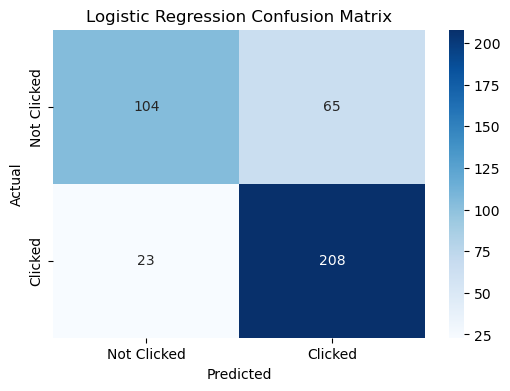

In [56]:
# Get predictions from pipeline
y_pred = lr_pipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Clicked', 'Clicked'],
            yticklabels=['Not Clicked', 'Clicked'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

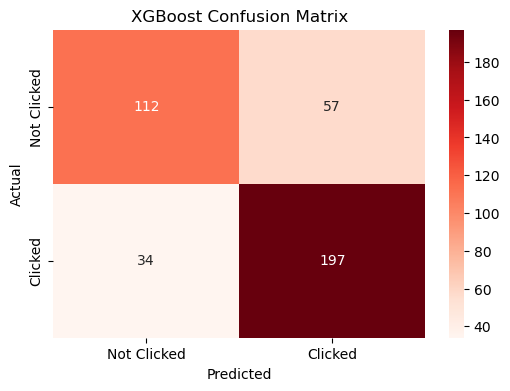

In [57]:
# Get predictions from pipeline
y_pred = xgb_pipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Clicked', 'Clicked'],
            yticklabels=['Not Clicked', 'Clicked'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

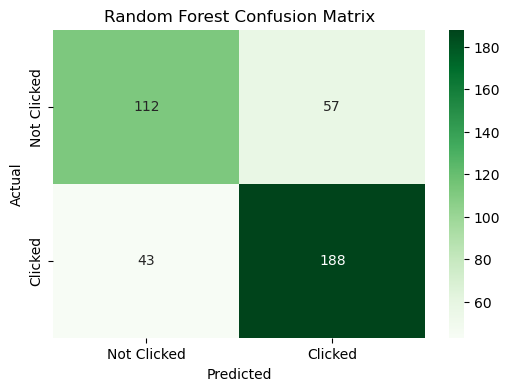

In [58]:
# Get predictions from pipeline
y_pred = rf_pipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Clicked', 'Clicked'],
            yticklabels=['Not Clicked', 'Clicked'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

## Model Comparison - ROC Curve of all 3 models

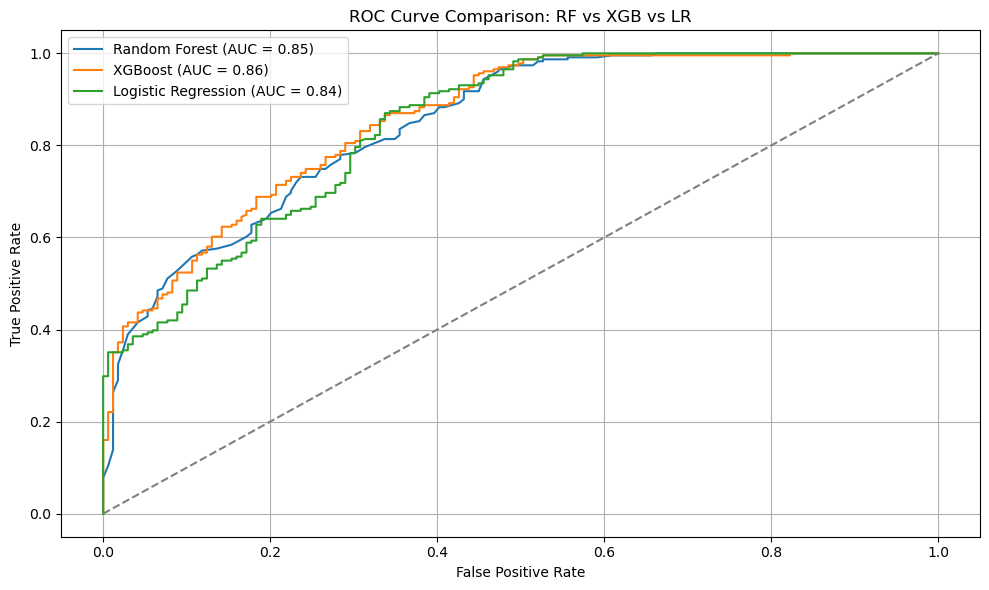

In [59]:
# Calculate ROC curve points
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: RF vs XGB vs LR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## GridSearch tuning for all 3 models

In [60]:
# GridSearch is a technique for finding the optimal parameter values from a given set of parameters in a grid

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # for reproducible folds/results


# Stratified KFold is useful for Stratified KFold is primarily useful for classification problems, especially when dealing with imbalanced datasets.
# It ensures that the class distribution is maintained across all folds during cross-validation, providing a more reliable estimate of model performance. 

In [61]:
# Random Forest GridSearch

In [62]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF AUC:", grid_rf.best_score_)
joblib.dump(grid_rf.best_estimator_, 'rf_tuned_model.pkl') # save newly tuned model

Best RF params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best RF AUC: 0.8403338003386149


['rf_tuned_model.pkl']

In [63]:
# XGBoost GridSearch

In [64]:
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1]
}

grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB AUC:", grid_xgb.best_score_)
joblib.dump(grid_xgb.best_estimator_, 'xgb_tuned_model.pkl') # save newly tuned model

Best XGB params: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}
Best XGB AUC: 0.8550844469891171


['xgb_tuned_model.pkl']

In [65]:
# Logistic Regression GridSearch

In [66]:
param_grid_lr = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR AUC:", grid_lr.best_score_)
joblib.dump(grid_lr.best_estimator_, 'lr_tuned_model.pkl') # save newly tuned model

Best LR params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best LR AUC: 0.8579989088751727


['lr_tuned_model.pkl']

## Combined Comparison Table for all three models

In [67]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lr)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lr)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lr)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lr)
    ],
    'AUC Score': [
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb),
        roc_auc_score(y_test, y_prob_lr)
    ]
})

# Round to 2 decimal places (except for the Model column)
results.iloc[:, 1:] = results.iloc[:, 1:].round(2)

print("Model Performance Summary")
print(results.sort_values(by="AUC Score", ascending=False).reset_index(drop=True))

Model Performance Summary
                 Model  Accuracy  Precision  Recall  F1 Score  AUC Score
0              XGBoost      0.77       0.78    0.85      0.81       0.86
1        Random Forest      0.75       0.77    0.81      0.79       0.85
2  Logistic Regression      0.78       0.76    0.90      0.83       0.84


## Visualize the Metrics with Bar Plots

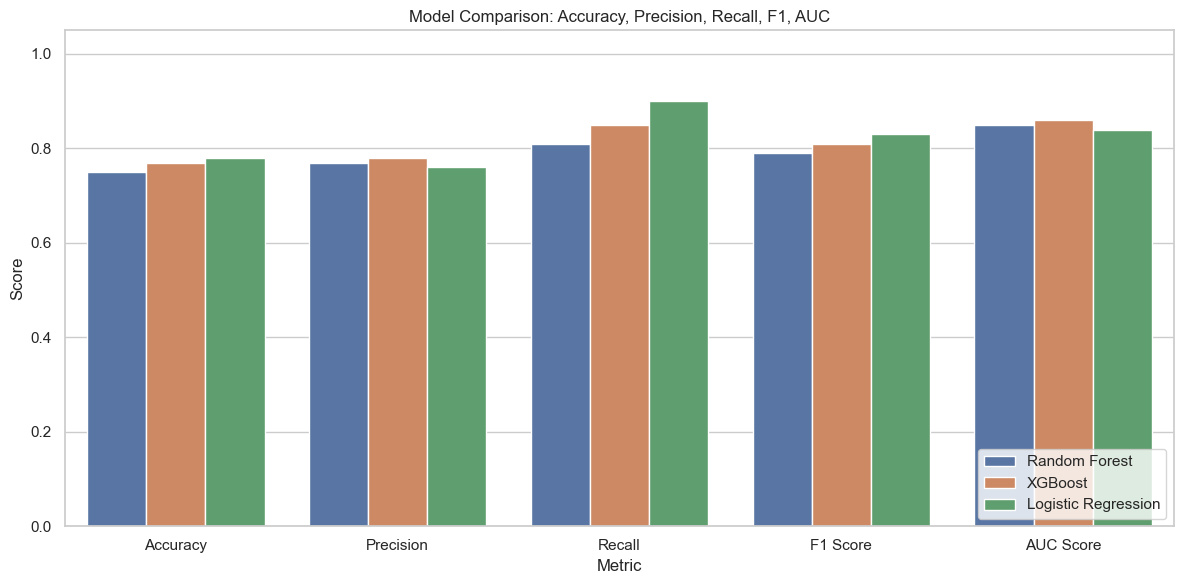

In [68]:
# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Melt the 'results' DataFrame for plotting
results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
sns.barplot(data=results_melted, x="Metric", y="Score", hue="Model")
plt.title("Model Comparison: Accuracy, Precision, Recall, F1, AUC")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [69]:
print(combined_df['clicked_on_ad'].value_counts()) # to view class distribution

clicked_on_ad
1    1157
0     843
Name: count, dtype: int64


In [70]:
print(combined_df['clicked_on_ad'].value_counts(normalize=True)) # to view class distribution in percentage

clicked_on_ad
1    0.5785
0    0.4215
Name: proportion, dtype: float64
